# ASMR Stock Analysis


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

# Load Stock Data

In [38]:
stock = pd.read_csv('./Ford.csv')
stock['Volume'] = stock['Vol']*100000
stock['Date'] = pd.to_datetime(stock['Date'])
# stock.drop(columns=['Change'], inplace=True)
stock.head()

,Date,Close,Open,High,Low,Vol,Change,Volume
0,2025-01-06,9.76,9.90,10.03,9.74,63.84,0.40,6384000.0
1,2025-01-07,9.61,9.79,9.85,9.57,62.40,-1.61,6240000.0
2,2025-01-08,9.59,9.59,9.60,9.43,61.68,-0.20,6168000.0
3,2025-01-10,9.50,9.52,9.68,9.44,73.37,-0.92,7337000.0
4,2025-01-13,9.56,9.51,9.57,9.42,66.02,0.62,6602000.0


In [39]:
# Calculate Moving Averages
# Calculate a 3-period Simple Moving Average (SMA)
stock['SMA_200d'] = stock['Close'].rolling(window=200).mean()
stock['SMA_100d'] = stock['Close'].rolling(window=100).mean()
stock['SMA_50d'] = stock['Close'].rolling(window=50).mean()
stock['SMA_21d'] = stock['Close'].rolling(window=21).mean()
stock['SMA_5d'] = stock['Close'].rolling(window=5).mean()
# stock['SMA_9d'] = stock['Close'].rolling(window=9).mean()
stock[['SMA_200d','SMA_100d','SMA_50d','SMA_21d','SMA_5d']].describe()

,SMA_200d,SMA_100d,SMA_50d,SMA_21d,SMA_5d
count,25.000000,125.000000,175.000000,204.000000,220.000000
mean,10.814846,10.777136,10.783592,10.828065,10.872655
std,0.118256,0.646053,0.879084,1.040640,1.140141
min,10.617150,9.843400,9.567000,9.331429,9.086000
25%,10.723250,10.228300,9.976700,9.803571,9.954000
50%,10.815350,10.720000,10.842400,10.646667,10.654000
75%,10.910500,11.274000,11.467100,11.648214,11.676000
max,11.011800,11.967300,12.470600,13.110476,13.306000


# Closing Prices

In [ ]:
sns.lineplot(x='Date',y='SMA_50d',data=stock,  label='50-Day SMA')
sns.lineplot(x='Date',y='SMA_21d',data=stock,  label='21-Day SMA')
sns.lineplot(x='Date',y='Close',data=stock,label='Close')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
sma = stock.query('Date >="2025-09-01"')
sns.lineplot(x='Date',y='SMA_50d',data=sma,  label='50-Day SMA')
sns.lineplot(x='Date',y='SMA_21d',data=sma,  label='21-Day SMA')
sns.lineplot(x='Date',y='SMA_5d',data=sma,  label='5-Day SMA')
sns.lineplot(x='Date',y='Close',data=sma,label='Close')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# LOESS Plotting

In [40]:
from statsmodels.nonparametric.smoothers_lowess import lowess

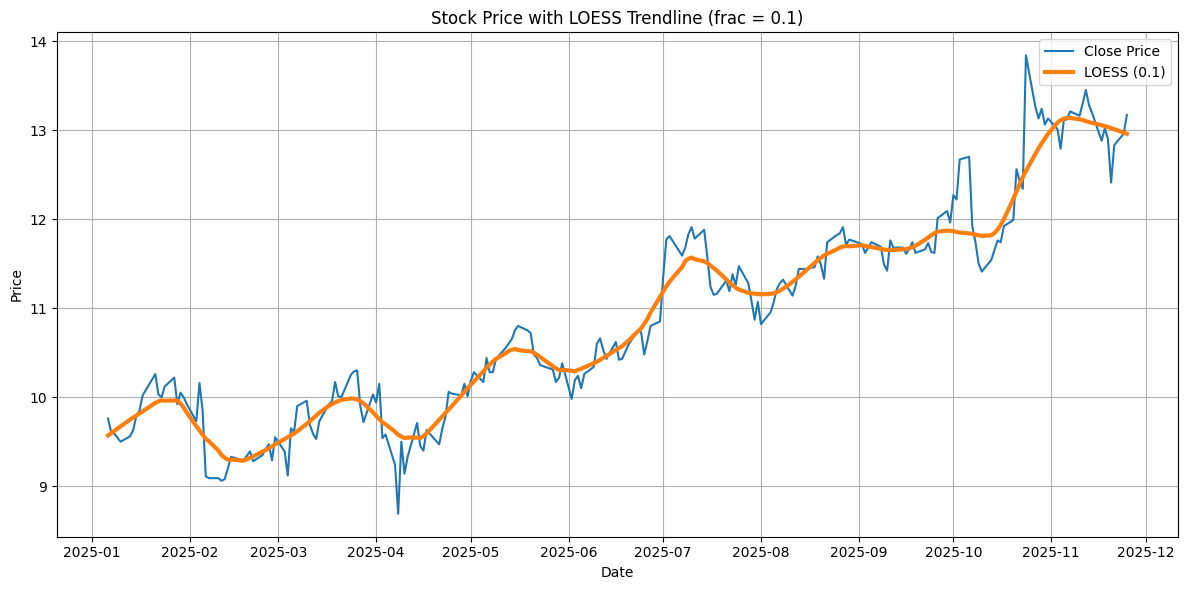

In [41]:
# Convert date column

# Sort by date (important for LOESS)
stock = stock.sort_values("Date").reset_index(drop=True)

# ---------------------------
# 2. Compute LOESS (frac = 0.1)
# ---------------------------
loess_result = lowess(
    endog=stock["Close"], 
    exog=stock["Date"].astype("int64"),   # convert datetime to numeric
    frac=0.1
)

# Add LOESS-smoothed values back to DataFrame
stock["LOESS_Close"] = loess_result[:, 1]

# ---------------------------
# 3. Plot Using Seaborn + Matplotlib
# ---------------------------
plt.figure(figsize=(12, 6))

# Original Close Price
sns.lineplot(data=stock, x="Date", y="Close", label="Close Price")

# LOESS Trendline
sns.lineplot(data=stock, x="Date", y="LOESS_Close", label="LOESS (0.1)", linewidth=3)

plt.title("Stock Price with LOESS Trendline (frac = 0.1)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()



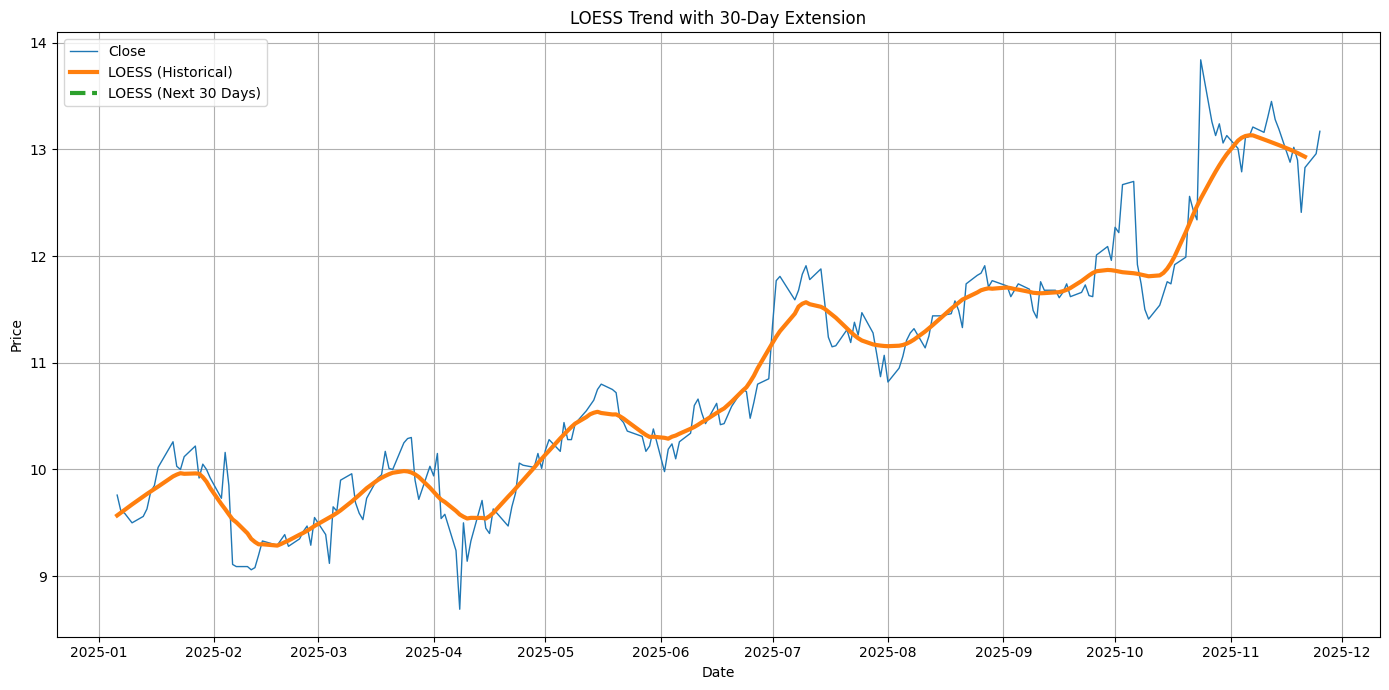

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure stock2 and loess_forecast_30 are already created
# (from the previous LOESS extension code)

plt.figure(figsize=(14, 7))

# -----------------------------
# 1. Plot historical close price
# -----------------------------
sns.lineplot(
    data=stock,
    x="Date",
    y="Close",
    label="Close",
    linewidth=1
)

# -----------------------------
# 2. Plot historical LOESS
# -----------------------------
sns.lineplot(
    data=stock2.iloc[:len(stock)],
    x="Date",
    y="LOESS",
    label="LOESS (Historical)",
    linewidth=3
)

# -----------------------------
# 3. Plot future LOESS extension
# -----------------------------
sns.lineplot(
    data=stock2.tail(30),
    x="Date",
    y="LOESS",
    label="LOESS (Next 30 Days)",
    linewidth=3,
    linestyle="--"
)

plt.title("LOESS Trend with 30-Day Extension")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


# LOESS Forecast

In [43]:
# stock has columns: Date, Close
stock["Date"] = pd.to_datetime(stock["Date"])
stock = stock.sort_values("Date").reset_index(drop=True)

# Optional: set Date as index for time-series modeling later
stock = stock.set_index("Date")

# Convert Date index to integer timestamps for LOESS exog
date_numeric = stock.index.astype("int64")

# LOESS smoothing (frac = 0.1 as you chose earlier)
loess_result = lowess(
    endog=stock["Close"],
    exog=date_numeric,
    frac=0.1,
    return_sorted=False
)

stock["Loess_Close"] = loess_result


In [44]:
y = stock["Loess_Close"].asfreq("B", method="pad")  # try to give it a BusinessDay freq


In [45]:
from pandas.tseries.offsets import BDay

last_date = stock.index[-1]
future_dates = pd.bdate_range(last_date + BDay(1), periods=30)


In [46]:
last_loess = y.iloc[-1]
naive_forecast = pd.Series(last_loess, index=future_dates, name="Naive")


In [47]:
ets_model = ExponentialSmoothing(
    y,
    trend="add",
    seasonal=None,
    initialization_method="estimated"
).fit()

ets_forecast = ets_model.forecast(30)
ets_forecast.index = future_dates  # ensure index matches
ets_forecast.name = "ETS"


In [48]:
arima_model = ARIMA(y, order=(1, 1, 1)).fit()

arima_forecast = arima_model.forecast(30)
arima_forecast.index = future_dates
arima_forecast.name = "ARIMA"


In [49]:
forecast_df = pd.concat(
    [naive_forecast, ets_forecast, arima_forecast],
    axis=1
)

print(forecast_df.head())


                Naive        ETS      ARIMA
2025-11-26  12.957814  12.937139  12.942011
2025-11-27  12.957814  12.917073  12.927588
2025-11-28  12.957814  12.897008  12.914426
2025-12-01  12.957814  12.876943  12.902413
2025-12-02  12.957814  12.856877  12.891449


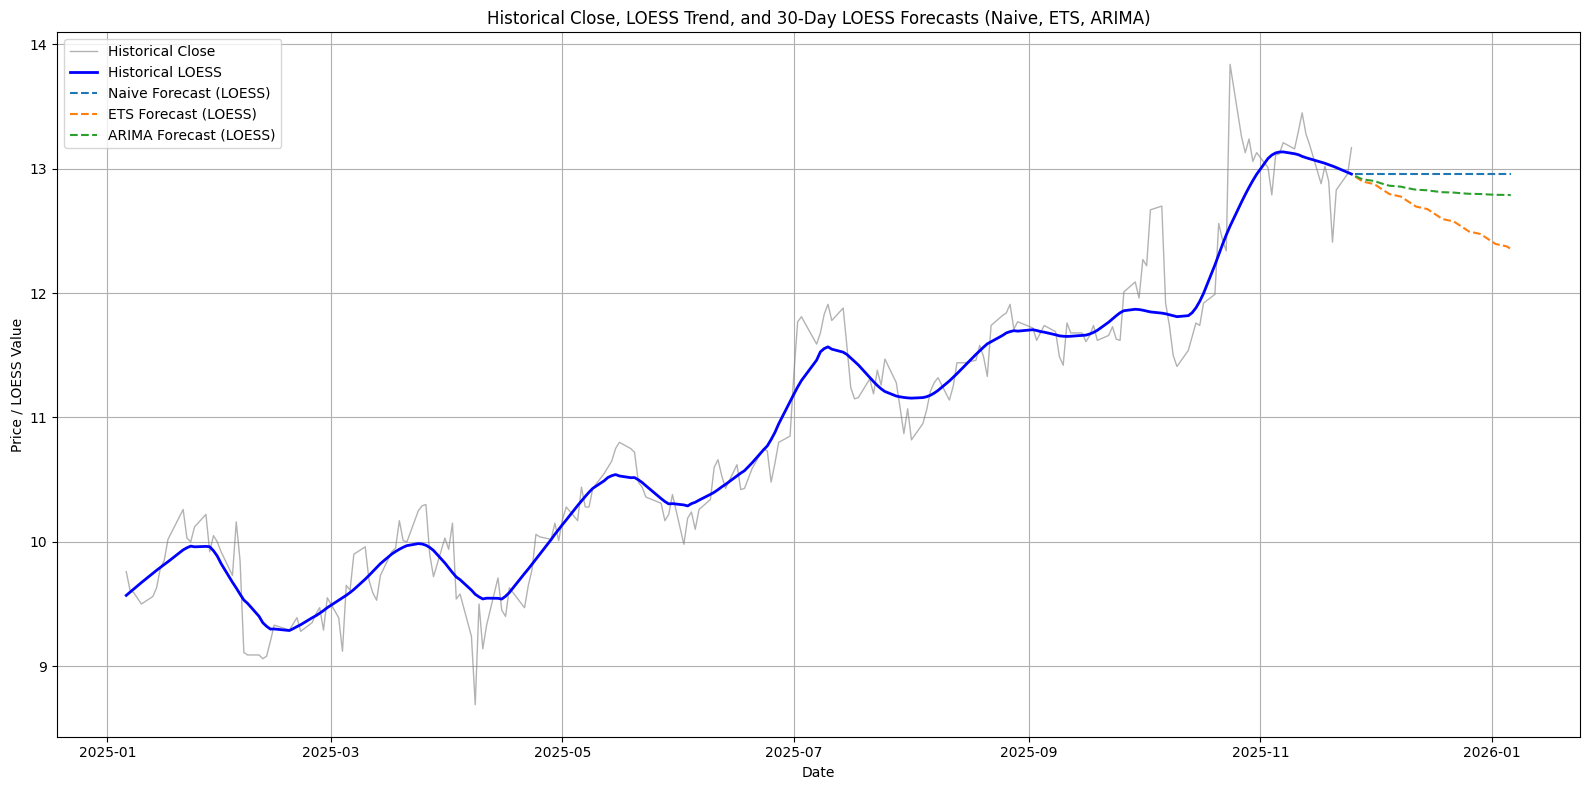

In [53]:
plt.figure(figsize=(16, 8))

# --------------------------------------
# HISTORICAL DATA
# --------------------------------------

# Historical Close price
plt.plot(
    stock.index,
    stock["Close"],
    label="Historical Close",
    color="gray",
    alpha=0.6,
    linewidth=1
)

# Historical LOESS series
plt.plot(
    stock.index,
    stock["Loess_Close"],
    label="Historical LOESS",
    color="blue",
    linewidth=2
)

# --------------------------------------
# FORECASTS
# --------------------------------------

# Naive forecast (LOESS)
plt.plot(
    forecast_df.index,
    forecast_df["Naive"],
    label="Naive Forecast (LOESS)",
    linestyle="--"
)

# ETS forecast (LOESS)
plt.plot(
    forecast_df.index,
    forecast_df["ETS"],
    label="ETS Forecast (LOESS)",
    linestyle="--"
)

# ARIMA forecast (LOESS)
plt.plot(
    forecast_df.index,
    forecast_df["ARIMA"],
    label="ARIMA Forecast (LOESS)",
    linestyle="--"
)

# --------------------------------------
# Formatting
# --------------------------------------

plt.title("Historical Close, LOESS Trend, and 30-Day LOESS Forecasts (Naive, ETS, ARIMA)")
plt.xlabel("Date")
plt.ylabel("Price / LOESS Value")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
# Save to png
plt.savefig("./ford_loess_forecast_2025_11_25.png")
plt.show()



# evaluate the accuracy of the forecast

In [31]:
y = stock["Loess_Close"]

# Create a complete range of business days between min and max date
bdays = pd.bdate_range(start=y.index.min(), end=y.index.max())

# Reindex to business days and forward fill missing values
y_b = y.reindex(bdays).ffill()
# y_b.index.freq = "B"   # <-- the key fix
y_b = y_b.asfreq("B")


In [32]:
# Number of backtest steps
h = 30  

# Split historical LOESS series
y_full = stock["Loess_Close"]
y_train = y_full.iloc[:-h]     # model training
y_test  = y_full.iloc[-h:]     # true future values


In [33]:
naive_fc = pd.Series(
    y_train.iloc[-1],
    index=y_test.index,
    name="Naive"
)


In [34]:
arima_model_bt = ARIMA(y_train, order=(1,1,1)).fit()
arima_fc = arima_model_bt.forecast(h)
arima_fc.name = "ARIMA"


/home/slacker1/py_env/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slacker1/py_env/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slacker1/py_env/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/slacker1/py_env/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

In [ ]:
ets_model_bt = ExponentialSmoothing(
    y_train,
    trend="add",
    seasonal=None,
    initialization_method="estimated"
).fit()

ets_fc = ets_model_bt.forecast(h)
ets_fc.name = "ETS"
